# Homework: Implement a Mixture of Experts Model

## Overview

In this homework, you'll implement a Mixture of Experts (MoE) model for classifying points generated from two Gaussian distributions.

Please submit your Jupyter Notebook with all the completed tasks and questions answered.

In [1]:
# Import Libraries

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate the Dataset
def generate_data(n_samples=2000):
  X = torch.zeros(n_samples, 2)
  y = torch.zeros(n_samples, dtype=torch.long)

  # Generate samples from two Gaussian distributions
  X[:n_samples//2] = torch.randn(n_samples//2, 2) + torch.Tensor([3,2])
  X[n_samples//2:] = torch.randn(n_samples//2, 2) + torch.Tensor([-3,2])

  # Labels
  for i in range(X.shape[0]):
    if X[i].norm() > math.sqrt(13):
      y[i] = 1

  X[:, 1] = X[:, 1] - 2

  return X, y

data, labels = generate_data()

Question: Plot the generated dataset. Do you think a linear model would be able to separate the classes well?

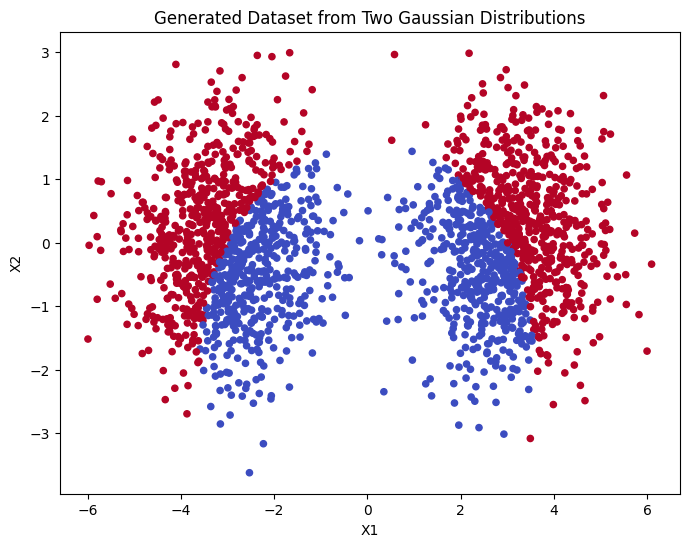

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0].numpy(), data[:, 1].numpy(), c=labels.numpy(), cmap='coolwarm', s=20)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Generated Dataset from Two Gaussian Distributions')
plt.show()

We can see an inherent non-linearilty in the decision boundary, therefore a linear model would struggle to classify it correctly. If used regardless, it will produce suboptimal classification performance.

## Expert Model

Task: Implement the Expert model. It should be a simple neural network with one linear layer.



In [4]:
class Expert(nn.Module):
    def __init__(self, input_dim=2, output_dim=2):
        super(Expert, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

## Gating Network

Task: Implement the Gating Network. It should output the probabilities for choosing each expert.

In [5]:
class GatingNetwork(nn.Module):
    def __init__(self, num_experts, input_dim=2):
        super(GatingNetwork, self).__init__()
        self.num_experts = num_experts
        # A simple linear layer to compute logits for each expert
        self.linear = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        # Compute raw scores for each expert
        logits = self.linear(x)
        # Convert logits to probabilities using softmax
        gating_probs = F.softmax(logits, dim=1)
        return gating_probs

## Mixture of Experts

Task: Implement the Mixture of Experts model. This model should utilize the Expert and Gating Network models to make a final prediction.

In [6]:
class MixtureOfExperts(nn.Module):
    def __init__(self, num_experts=2, input_dim=2, output_dim=2):
        super(MixtureOfExperts, self).__init__()
        # Create a list of expert models
        self.experts = nn.ModuleList([Expert(input_dim, output_dim) for _ in range(num_experts)])
        # Initialize the gating network which outputs probabilities for each expert
        self.gating_network = GatingNetwork(num_experts, input_dim)

    def forward(self, x):
        # Compute gating probabilities for each expert: shape (batch_size, num_experts)
        gating_probs = self.gating_network(x)
        # Compute outputs from each expert: list of (batch_size, output_dim)
        # Stack them to get shape (batch_size, num_experts, output_dim)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        # Weight each expert's output with the gating probability and sum over experts.
        # gating_probs is unsqueezed to shape (batch_size, num_experts, 1) for broadcasting.
        final_output = (expert_outputs * gating_probs.unsqueeze(2)).sum(dim=1)
        return final_output

## Training Loop

Task: Write a training loop to train the Mixture of Experts model. Use binary cross-entropy loss and an Adam optimizer. Also, implement a learning rate scheduler that decays the learning rate.

In [7]:
# Define the model, loss, and optimizer
model = MixtureOfExperts(num_experts=2, input_dim=2, output_dim=1)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(data_tensor)
    predictions = torch.sigmoid(outputs)  # Convert raw outputs to probabilities
    loss = criterion(predictions, labels_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Decay the learning rate
    scheduler.step()

    # Compute accuracy
    predicted_labels = (predictions > 0.5).float()
    accuracy = (predicted_labels.eq(labels_tensor).sum().item() / len(labels_tensor)) * 100

    # Print out the loss and accuracy every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

Epoch [100/1000], Loss: 0.3887, Accuracy: 82.40%
Epoch [200/1000], Loss: 0.2924, Accuracy: 87.15%
Epoch [300/1000], Loss: 0.2563, Accuracy: 88.80%
Epoch [400/1000], Loss: 0.2390, Accuracy: 89.50%
Epoch [500/1000], Loss: 0.2290, Accuracy: 90.10%
Epoch [600/1000], Loss: 0.2223, Accuracy: 90.40%
Epoch [700/1000], Loss: 0.2174, Accuracy: 90.90%
Epoch [800/1000], Loss: 0.2135, Accuracy: 91.30%
Epoch [900/1000], Loss: 0.2103, Accuracy: 91.40%
Epoch [1000/1000], Loss: 0.2075, Accuracy: 91.60%


## Decision Boundaries
Task: Plot the decision boundaries of the two experts, the gating network and the final model

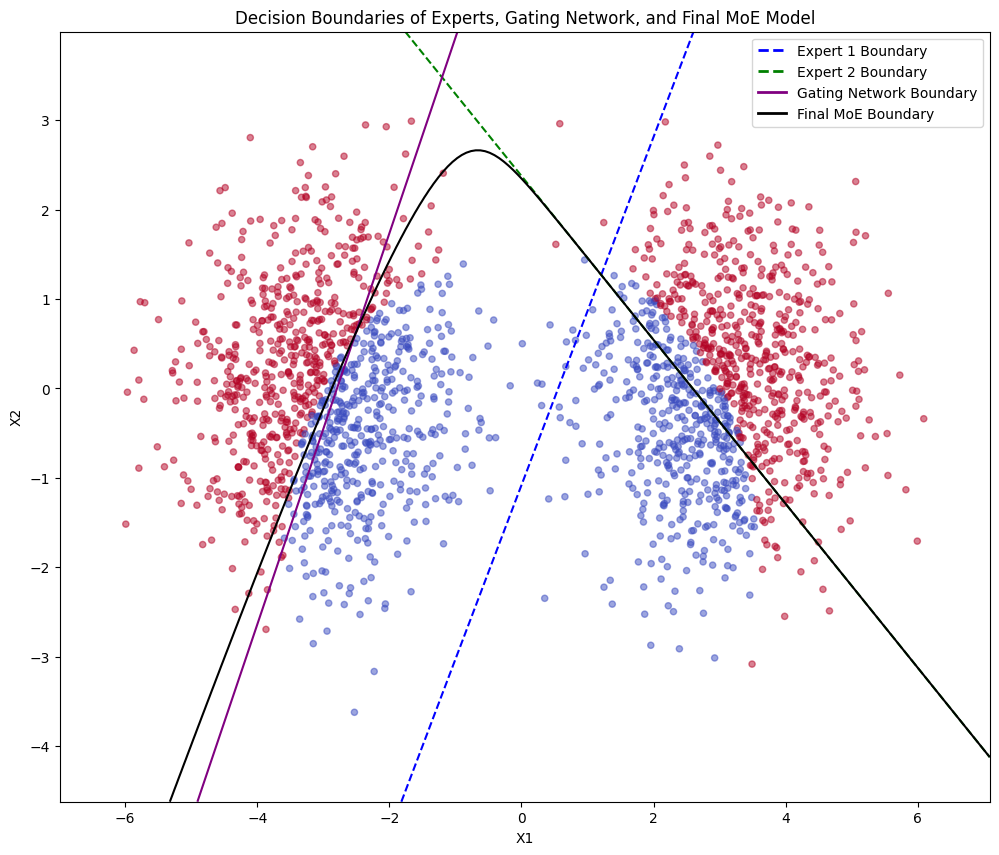

In [ ]:
# Define grid boundaries based on the data range
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.FloatTensor(grid)

with torch.no_grad():
    # Expert 1 decision boundary
    # Get the raw logits for expert 1 and reshape to grid
    Z_expert1 = model.experts[0](grid_tensor)
    Z_expert1 = Z_expert1.view(xx.shape).numpy()

    # Expert 2 decision boundary
    Z_expert2 = model.experts[1](grid_tensor)
    Z_expert2 = Z_expert2.view(xx.shape).numpy()

    # Gating network decision boundary
    gating_logits = model.gating_network.linear(grid_tensor)  # raw logits from the gating layer
    # Difference between the logits for expert 1 and expert 2
    diff = gating_logits[:, 0] - gating_logits[:, 1]
    diff = diff.view(xx.shape).numpy()

    # Final MoE decision boundary
    Z_final = model(grid_tensor)
    Z_final = Z_final.view(xx.shape).numpy()

# Plotting the decision boundaries and data points
plt.figure(figsize=(12, 10))
# Scatter plot of the original data
plt.scatter(data[:, 0].numpy(), data[:, 1].numpy(), c=labels.numpy(), cmap='coolwarm', s=20, alpha=0.5)

# Plot Expert 1 boundary (where expert 1 logit = 0)
contour_expert1 = plt.contour(xx, yy, Z_expert1, levels=[0], colors='blue', linestyles='dashed')
# Plot Expert 2 boundary (where expert 2 logit = 0)
contour_expert2 = plt.contour(xx, yy, Z_expert2, levels=[0], colors='green', linestyles='dashed')
# Plot Gating network boundary (where the difference of logits = 0, meaning p1 = p2)
contour_gate = plt.contour(xx, yy, diff, levels=[0], colors='purple', linestyles='solid')
# Plot Final MoE boundary (where final logit = 0)
contour_final = plt.contour(xx, yy, Z_final, levels=[0], colors='black', linestyles='solid')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, linestyle='dashed', label='Expert 1 Boundary'),
    Line2D([0], [0], color='green', lw=2, linestyle='dashed', label='Expert 2 Boundary'),
    Line2D([0], [0], color='purple', lw=2, linestyle='solid', label='Gating Network Boundary'),
    Line2D([0], [0], color='black', lw=2, linestyle='solid', label='Final MoE Boundary')
]
plt.legend(handles=legend_elements, loc='best')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Boundaries of Experts, Gating Network, and Final MoE Model')
plt.show()

Question: Analyze the decision boundaries. What differences do you observe between the experts? How does the gating network decide between the two?

Each expert learned a different linear boundary, with distinct orientations. The Gating Network boundary marks where the model switches between experts. On one side Expert 1 is weighted more, and on the other, Expert 2 is dominant. Final Mixture of Experts bounday is non-linear blending the two linear expert boundaries using the gating network.

## Bonus Task (2 points)
Try increasing the number of experts. How does the model complexity and decision boundary change? (You don't need to show your code for the new models, just plot the new decision boundaries and explain what did you find from the plots)



In [ ]:
def train_moe(num_experts, num_epochs=1000, lr=0.01):
    model = MixtureOfExperts(num_experts=num_experts, input_dim=2, output_dim=1)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

    data_tensor = data.float()
    labels_tensor = labels.view(-1, 1).float()

    for epoch in range(num_epochs):
        outputs = model(data_tensor)
        predictions = torch.sigmoid(outputs)
        loss = criterion(predictions, labels_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return model

# Train models with 2, 3, 4, and 5 experts
models = {
    2: train_moe(2),
    3: train_moe(3),
    4: train_moe(4),
    5: train_moe(5)
}

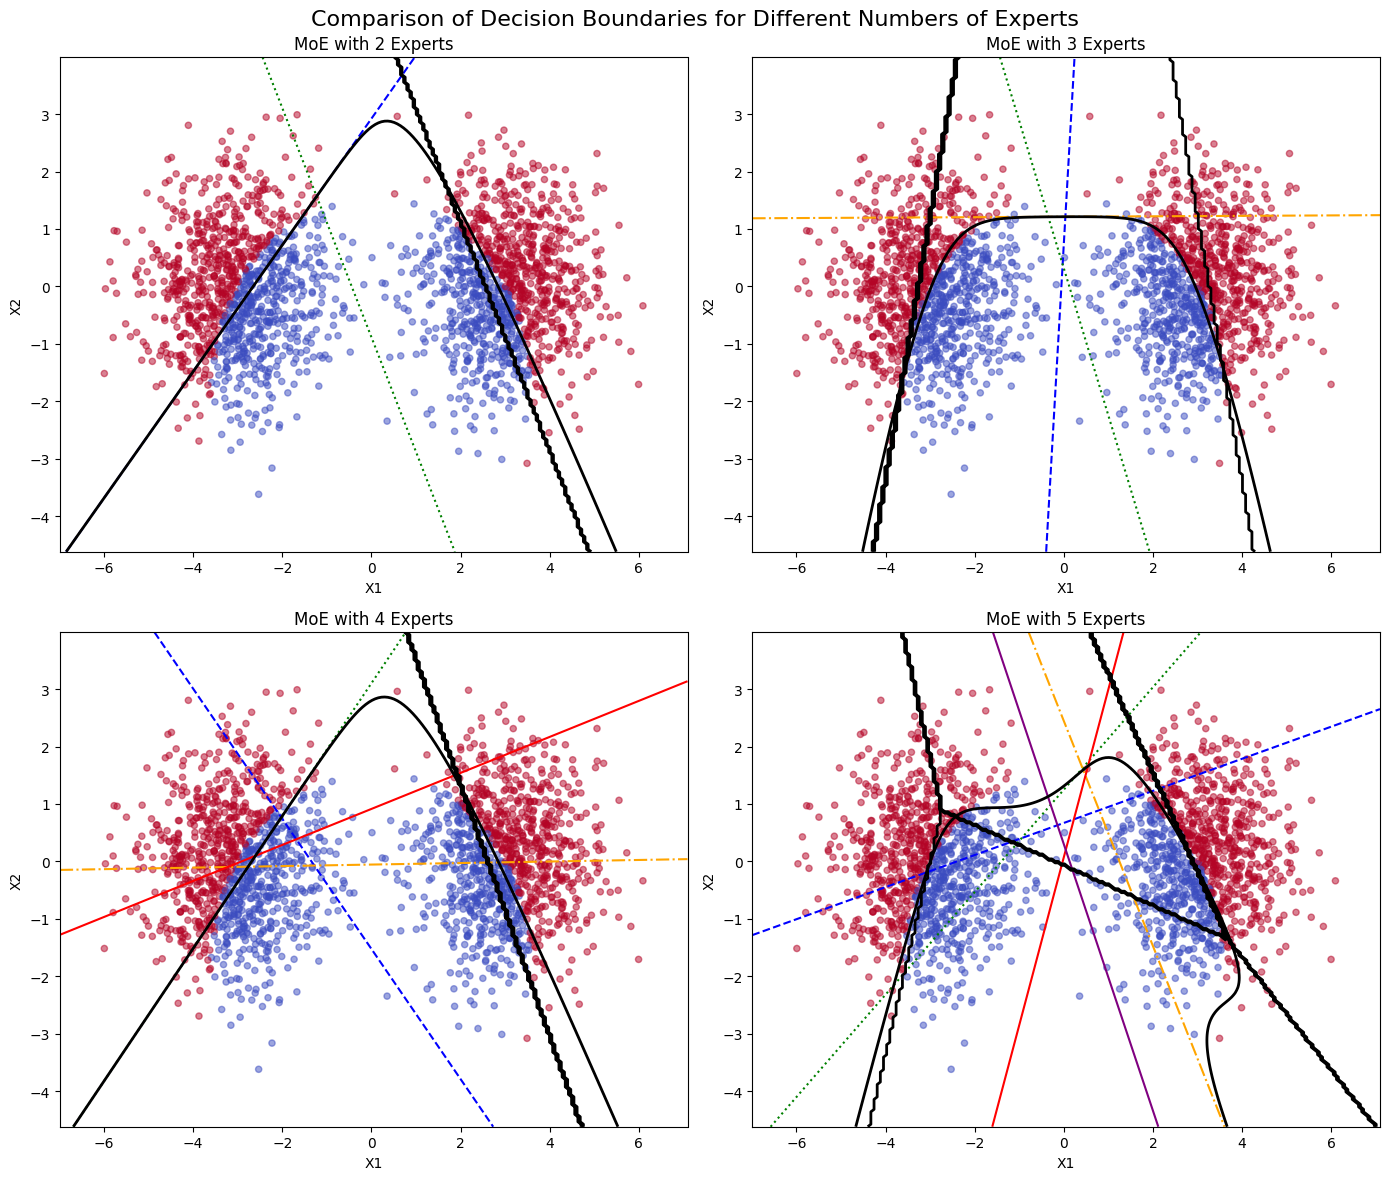

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.FloatTensor(grid)

num_experts_list = [2, 3, 4, 5]
colors = ['blue', 'green', 'orange', 'red', 'purple']
linestyles = ['dashed', 'dotted', 'dashdot', 'solid', 'solid']

for idx, num_experts in enumerate(num_experts_list):
    model = models[num_experts]
    with torch.no_grad():
        # Evaluate experts
        expert_outputs = [model.experts[j](grid_tensor).view(xx.shape).numpy() for j in range(num_experts)]

        # Evaluate gating network
        gating_logits = model.gating_network.linear(grid_tensor)  # Raw logits
        gating_probs = F.softmax(gating_logits, dim=1).numpy()
        gating_decision = np.argmax(gating_probs, axis=1).reshape(xx.shape)  # Assigning regions to experts

        # Evaluate final MoE model
        Z_final = model(grid_tensor).view(xx.shape).numpy()

    ax = axes[idx // 2, idx % 2]
    ax.scatter(data[:, 0].numpy(), data[:, 1].numpy(), c=labels.numpy(), cmap='coolwarm', s=20, alpha=0.5)

    # Plot expert boundaries
    for j in range(num_experts):
        ax.contour(xx, yy, expert_outputs[j], levels=[0], colors=colors[j], linestyles=linestyles[j], linewidths=1.5)

    # Plot gating network boundaries
    ax.contour(xx, yy, gating_decision, levels=num_experts - 1, colors='black', linestyles='solid', linewidths=2)

    # Plot final MoE decision boundary
    ax.contour(xx, yy, Z_final, levels=[0], colors='black', linewidths=2)

    ax.set_title(f'MoE with {num_experts} Experts')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

plt.suptitle('Comparison of Decision Boundaries for Different Numbers of Experts', fontsize=16)
plt.tight_layout()
plt.show()

We can clearly see that the model complexity increases with more number of experts as we transition from lower to higher flexibility. The decision boundary transforms from roughly piecewise linear to being smoother and more adaptable. But at the same time, as with any ML model, we can also clearly see the bias-variance trade-off at play and as we increase the number of experts, we tend to approach overfitting-like behaviour.